<a href="https://colab.research.google.com/github/shadinn/Jaringan-POI-Wisata-Bandung/blob/main/%5BPROJECT_SNA%5D_Analisis_POI_WIsata_Bandung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from math import radians, sin, cos, sqrt, atan2

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/belajar/data/Data POI.xlsx')
df.head()

,Kode,Nama,Jenis,Lat,Lon
0,POI1,Trans Studio Bandung,Rekreasi,-6.924398,107.635952
1,POI2,Kebon binatang bandung,Rekreasi,-6.890036,107.606845
2,POI3,Museum Geology,Museum,-6.900701,107.621475
3,POI4,Museum Asia Afrika,Museum,-6.921051,107.609607
4,POI5,Museum Pos Indonesia,Museum,-6.901894,107.619458


In [ ]:
# Batasan koordinat wilayah Kota Bandung
latitude_min = -6.95
latitude_max = -6.85
longitude_min = 107.55
longitude_max = 107.70

# Filtering dataframe berdasarkan batasan koordinat
df_bandung = df[(df['Lat'] >= latitude_min) & (df['Lat'] <= latitude_max) &
                (df['Lon'] >= longitude_min) & (df['Lon'] <= longitude_max)]

# Menampilkan dataframe hasil seleksi
print(df_bandung)


         Kode                             Nama     Jenis       Lat         Lon
0        POI1             Trans Studio Bandung  Rekreasi -6.924398  107.635952
1        POI2           Kebon binatang bandung  Rekreasi -6.890036  107.606845
2        POI3                   Museum Geology    Museum -6.900701  107.621475
3        POI4               Museum Asia Afrika    Museum -6.921051  107.609607
4        POI5             Museum Pos Indonesia    Museum -6.901894  107.619458
...       ...                              ...       ...       ...         ...
1801  POI1803                    DE REIZ VILLA     Hotel -6.860373  107.646709
1802  POI1805  PENGINAPAN LOSMEN YANTI BANDUNG     Hotel -6.944570  107.595515
1803  POI1806             LOSMEN LEUWI PANJANG     Hotel -6.945347  107.594850
1804  POI1807            TAB CAPSULE & COMPACT     Hotel -6.934209  107.602949
1805  POI1808               THE SUITES @ METRO     Hotel -6.937394  107.659247

[1694 rows x 5 columns]


In [ ]:
# Kata kunci yang ingin dihapus
kata_kunci = ['AYAM','IKAN','BAKSO','BASO','NASI','MAKAN','RM','DAGO','SUKI','BURGER','GRILL','KEDAI','RUMAH'
              'BATAGOR','BEBEK','RESTAURANT','KARTIKA','MIH','RAMEN','BAKERY','BEBEKE','BASKIN','GEPREK','CEKERAN',
              'MAYASARI','KITCHEN','BUMI','WARUNG','PORKIYMIE','TUTUT','CAKE','PIZZA','RESTAURANT','ROEMAH','SHABU',
              'SANTAP','CAU','FRIED','CHICKEN','NGIKAN','SERJA','MI','MIE','KWETIAU','SOTO','BBQ','THAI','KING','SOP',
              'ANGKRINGAN','GUDEG','CAKES','IGA','CHINESE','LONTONG','SERBU','NYAPII','OSENG','SOTO','SUKI','SAUNG',
              'RESTO','KANTIN','KEPITING','OMAH','RESTORAN','90','SARI','GORENG','KOREAN','PATISSERIE','KATSUNYAKA',
              'STEAK','CABANG','BAKMIE','RESTORAN','BOWL','SUSHI','SATE','GRILL','DAUN','GEPUK','RESTO','SEDERHANA',
              'JAPANESE','ACI','PASAR','KHAO','PADANG','PILLOW','KANTIN', 'LA','GION', 'REDSDIPO','JOGLO','TIAN',
              'PASTA','CENTRE','PUNCLUT','PORK','SEAFOOD','BUFET','BISTRO','MARKET','ZENBU','BAKAR','MISS','SUNDA',
              'SEDEP','BURGER','PERMAI','ITALIAN','BOBOWL','JUMBO','PAVILLON','LALUNE','KITCHEN','BOSTON','SAMO',
              'TOSERBA','RASA','HONG','YAMI','NOODLE','INDIA','HANAMASA','CUANKI','SAMBEL','TIAM','TSM','MENDJAMU',
              'JAWA','KAMPUNG','DAPUR','RICHEESE','GEDOAN','DIMSUM','DAPURLAUT','CIPAGANTI','BISTIK','WENDY','CRAB',
              'STRAWBERRY','KEBAB','PIZZERIA','MANGKOK','MIXUE','BUNDO','DONAT','MERDEKA','ZUKI','GUA']

df_bandung = df_bandung[~df_bandung['Nama'].str.contains('|'.join(kata_kunci))]
print(df_bandung)


         Kode                             Nama     Jenis       Lat         Lon
0        POI1             Trans Studio Bandung  Rekreasi -6.924398  107.635952
1        POI2           Kebon binatang bandung  Rekreasi -6.890036  107.606845
2        POI3                   Museum Geology    Museum -6.900701  107.621475
3        POI4               Museum Asia Afrika    Museum -6.921051  107.609607
4        POI5             Museum Pos Indonesia    Museum -6.901894  107.619458
...       ...                              ...       ...       ...         ...
1799  POI1801  ARE YOU AND I BED AND BREAKFAST     Hotel -6.883806  107.648855
1802  POI1805  PENGINAPAN LOSMEN YANTI BANDUNG     Hotel -6.944570  107.595515
1803  POI1806             LOSMEN LEUWI PANJANG     Hotel -6.945347  107.594850
1804  POI1807            TAB CAPSULE & COMPACT     Hotel -6.934209  107.602949
1805  POI1808               THE SUITES @ METRO     Hotel -6.937394  107.659247

[878 rows x 5 columns]


In [ ]:
df = df_bandung

# Jarak

In [ ]:
# Fungsi untuk menghitung jarak Haversine antara dua titik koordinat
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius bumi dalam kilometer

    # Konversi ke radian
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Selisih koordinat
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Rumus Haversine
    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c

    return distance

In [ ]:
# Membuat dataframe baru untuk menyimpan hasil jarak
df_distances = pd.DataFrame(columns=['POIA','POIB', 'NamaA','NamaB', 'Distance', 'IsClose'])

# Menghitung jarak Haversine antara setiap baris dengan baris pertama, dan berulang dengan setiap baris hingga baris terakhir
for i in range(len(df)):
    lat1 = df['Lat'].iloc[i]
    lon1 = df['Lon'].iloc[i]
    for j in range(len(df)):
        if i == j:
            continue
        lat2 = df['Lat'].iloc[j]
        lon2 = df['Lon'].iloc[j]
        distance = haversine(lat1, lon1, lat2, lon2)

        # Menambahkan data jarak dan keterangan ke dataframe baru
        poi1 = df['Kode'].iloc[i]
        poi2 = df['Kode'].iloc[j]
        poi3 = df['Nama'].iloc[i]
        poi4 = df['Nama'].iloc[j]
        is_close = 1 if distance < 1 else 0
        #df_temp = pd.DataFrame({'POI': [f'{poi1} - {poi2}'], 'Distance': [distance], 'IsClose': [is_close]})
        df_temp = pd.DataFrame({'POIA': [poi1],'POIB': [poi2],'NamaA':[poi3], 'NamaB' : [poi4] , 'Distance': [distance], 'IsClose': [is_close]})
        df_distances = pd.concat([df_distances, df_temp], ignore_index=True)

print(df_distances)


In [ ]:
filtered_df = df_distances.loc[df_distances['IsClose'] == 1]
print(filtered_df)

       POIA   POIB                      NamaA  \
9      POI1  POI11       Trans Studio Bandung   
29     POI1  POI31       Trans Studio Bandung   
94     POI2  POI15     Kebon binatang bandung   
102    POI2  POI23     Kebon binatang bandung   
112    POI2  POI33     Kebon binatang bandung   
...     ...    ...                        ...   
6624  POI82  POI64  Perpustakaan Kota Bandung   
6625  POI82  POI65  Perpustakaan Kota Bandung   
6626  POI82  POI66  Perpustakaan Kota Bandung   
6629  POI82  POI69  Perpustakaan Kota Bandung   
6630  POI82  POI70  Perpustakaan Kota Bandung   

                                 NamaB  Distance IsClose  
9                 Bandung Creative Hub  0.825405       1  
29                   TRANS STUDIO MALL  0.133322       1  
94       Babakan Siliwangi City Forest  0.663181       1  
102                             CIWALK  0.297854       1  
112           TERAS CIHAMPELAS BANDUNG  0.499554       1  
...                                ...       ...     ... 

In [ ]:
filtered_df.to_excel('distances.xlsx', index=False)

In [ ]:
# Menggabungkan data dari Kolom1 dan Kolom2 ke KolomBaru tanpa duplikasi
kolom_baru = set(filtered_df['POIA']).union(set(filtered_df['POIB']))

# Mengonversi set menjadi list
kolom_baru = list(kolom_baru)

# Membuat DataFrame baru dengan KolomBaru
data_nodes = pd.DataFrame({'POI': kolom_baru})

print(data_nodes)

      POI
0   POI28
1   POI33
2   POI80
3   POI69
4   POI77
5   POI78
6    POI1
7   POI15
8   POI36
9   POI65
10   POI6
11   POI7
12  POI67
13  POI17
14  POI72
15  POI30
16   POI2
17  POI34
18  POI40
19  POI50
20  POI54
21  POI68
22  POI29
23  POI61
24  POI62
25  POI19
26  POI74
27  POI45
28  POI56
29  POI23
30   POI5
31  POI73
32  POI16
33  POI49
34  POI11
35   POI3
36  POI82
37  POI66
38  POI39
39  POI13
40  POI31
41  POI76
42  POI41
43  POI52
44  POI58
45  POI71
46  POI32
47   POI4
48  POI20
49  POI57
50  POI12
51  POI38
52  POI64
53  POI63
54  POI59
55  POI10
56  POI55
57  POI70
58  POI53
59  POI75


In [ ]:
data_nodes.to_excel('data_nodes.xlsx', index=False)

# Analisis Jaringan
Analisis Jaringan: Terapkan metode dan metrik SNA untuk menganalisis jaringan POI. Beberapa metrik yang berguna dalam analisis ini meliputi:

* Degree Centrality: Mengukur seberapa banyak koneksi yang dimiliki oleh simpul dalam jaringan. Simpul dengan derajat yang tinggi memiliki lebih banyak koneksi dan dianggap lebih sentral.

* Betweenness Centrality: Mengukur sejauh mana sebuah simpul berada di jalur terpendek antara simpul lain dalam jaringan. Simpul dengan betweenness centrality yang tinggi berperan penting dalam menghubungkan simpul-simpul lain dalam jaringan.

* Closeness Centrality: Mengukur seberapa cepat sebuah simpul dapat dijangkau oleh simpul-simpul lain dalam jaringan. Simpul dengan closeness centrality yang tinggi berada lebih dekat dengan simpul-simpul lain dalam jaringan.

* Eigenvector Centrality: Mengukur seberapa sentral sebuah simpul berdasarkan kedekatan dengan simpul-simpul sentral lain dalam jaringan. Simpul dengan eigenvector centrality yang tinggi terhubung dengan simpul-simpul yang penting.

* PageRank: Metode yang digunakan untuk mengukur tingkat pentingnya sebuah simpul dalam jaringan berdasarkan keterhubungannya dengan simpul-simpul lainnya. Metode ini mirip dengan algoritma yang digunakan oleh mesin pencari Google.

In [ ]:
G = nx.Graph()

for index, row in filtered_df.iterrows():
    G.add_edge(row['NamaA'], row['NamaB'], weight=row['Distance'])


In [ ]:
# Degree
degree = nx.degree(G)
degree = pd.DataFrame(degree)
degree.head()

,0,1
0,Trans Studio Bandung,2
1,Bandung Creative Hub,3
2,TRANS STUDIO MALL,3
3,Kebon binatang bandung,5
4,Babakan Siliwangi City Forest,3


In [ ]:
# Degree Centrality
deg_cen = nx.degree_centrality(G)
sorted(deg_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('BRAGA CITY WALK', 0.3389830508474576),
 ('Taman Vanda', 0.3389830508474576),
 ('Taman Dewi Sartika', 0.3220338983050847),
 ('Gor dan Taman Saparua', 0.3050847457627119),
 ('Jalan Braga', 0.288135593220339)]

In [ ]:
df_degree_centrality = pd.DataFrame.from_dict(deg_cen, orient='index', columns=['Degree Centrality'])
df_degree_centrality.index.name = 'Node'
df_degree_centrality.to_excel('degree.xlsx', index=True)

In [ ]:
# Betweenness Centrality
bet_cen = nx.betweenness_centrality(G)
sorted(bet_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Gor dan Taman Saparua', 0.20494245765507813),
 ('Taman Pramuka', 0.15780245470485096),
 ('ITC KEBON KELAPA', 0.13793103448275862),
 ('BANDUNG INDAH PLAZA', 0.09739025245491922),
 ('Taman Vanda', 0.09116772013053379)]

In [ ]:
df_betweenness_centrality = pd.DataFrame.from_dict(bet_cen, orient='index', columns=['Betweenness Centrality'])
df_betweenness_centrality.index.name = 'Node'
df_betweenness_centrality.to_excel('Betweenness.xlsx', index=True)

In [ ]:
#Closeness Centrality
clos_cen = nx.closeness_centrality(G)
sorted(clos_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Gor dan Taman Saparua', 0.40444720883221896),
 ('Taman Vanda', 0.39013049347532625),
 ('Taman Dewi Sartika', 0.38670829616413915),
 ('BANDUNG INDAH PLAZA', 0.38334561532792927),
 ('Taman Balai Kota', 0.37679269882659716)]

In [ ]:
df_closeness_centrality = pd.DataFrame.from_dict(clos_cen, orient='index', columns=['Closeness Centrality'])
df_closeness_centrality.index.name = 'Node'
df_closeness_centrality.to_excel('Closeness.xlsx', index=True)

In [ ]:
#Page Rank
page_rank = nx.pagerank(G)
sorted(page_rank.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Gor dan Taman Saparua', 0.030565035863342888),
 ('Tepi Kota Healing', 0.027568748811837365),
 ('Taman Vanda', 0.02752935472941162),
 ('BRAGA CITY WALK', 0.02737613718470311),
 ('Taman Dewi Sartika', 0.02589629569639812)]

In [ ]:
df_page_rank = pd.DataFrame.from_dict(page_rank, orient='index', columns=['Page Rank'])
df_page_rank.index.name = 'Node'
df_page_rank.to_excel('PageRank.xlsx', index=True)

In [ ]:
# Eigenvector
eig_cen = nx.eigenvector_centrality(G)
sorted(eig_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('BRAGA CITY WALK', 0.27686646322125286),
 ('Taman Vanda', 0.2761269852564818),
 ('Taman Dewi Sartika', 0.2639703639534752),
 ('Jalan Braga', 0.2456769071594348),
 ('Taman Balai Kota', 0.22421789392996783)]

In [ ]:
df_Eigenvector_centrality = pd.DataFrame.from_dict(eig_cen, orient='index', columns=['Eigenvector Centrality'])
df_Eigenvector_centrality.index.name = 'Node'
df_Eigenvector_centrality.to_excel('Eigenvector.xlsx', index=True)

In [ ]:
# Density
density = 2 * G.size(weight='weight') / (len(G) * (len(G) - 1))
density

0.6818308033012269

# Clique



In [ ]:
# Cliques
cliques = nx.find_cliques(G)
for clique in cliques:
    print("Clique:", clique)

Clique: ['Sudirman Market', 'Asia Afrika Fountain', 'Museum Asia Afrika', 'Masjid Raya Bandung', 'Cibadak Culinary', 'PASAR BARU TRADE CENTER', 'GRAND YOGYA KEPATIHAN', 'THE KINGS SHOPPING CENTRE', 'Alun-Alun Bandung', 'Teras Cikapundung', 'Jalan Dalem Kaum ']
Clique: ['Pasar Cisangkuy', 'Gasibu', 'Gedung Sate', 'Museum Pos Indonesia', 'Museum Geology', 'Monumen Rakyat Jawa Barat', 'Dipatiukur Streed Food']
Clique: ['Pasar Cisangkuy', 'Gasibu', 'Gedung Sate', 'Museum Pos Indonesia', 'Museum Geology', 'Museum Gedung Sate', 'Taman Lansia', 'Dipatiukur Streed Food']
Clique: ['Pasar Cisangkuy', 'Gasibu', 'Gedung Sate', 'Museum Pos Indonesia', 'Museum Geology', 'Museum Gedung Sate', 'Taman Lansia', 'Pusat Dakwah Islam (Pusdai)', 'Cibeunying Streed Food', 'Taman Pustaka Bunga Kandaga Puspa']
Clique: ['Pasar Cisangkuy', 'Gasibu', 'Gedung Sate', 'Museum Pos Indonesia', 'Gor dan Taman Saparua', 'Cibeunying Streed Food', 'Taman Lansia', 'Museum Gedung Sate', 'Taman Pustaka Bunga Kandaga Puspa']


In [ ]:
largest_clique = sorted(nx.find_cliques(G), key=lambda x:len(x))[-1]
largest_clique

['BRAGA CITY WALK',
 'Taman Vanda',
 'GRAND YOGYA KEPATIHAN',
 'Asia Afrika Fountain',
 'Museum Asia Afrika',
 'Jalan Braga',
 'Masjid Raya Bandung',
 'Alun-Alun Bandung',
 'Teras Cikapundung',
 'PASAR BARU TRADE CENTER',
 'Jalan Dalem Kaum ']

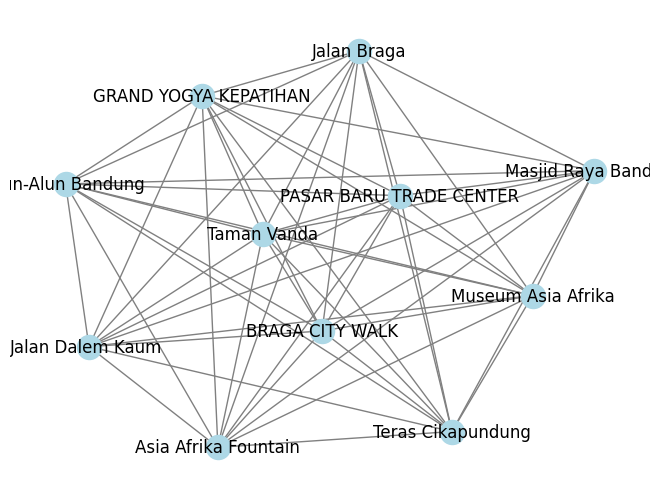

In [ ]:
subgraph = G.subgraph(largest_clique)

# Menampilkan visualisasi jaringan
nx.draw(subgraph, with_labels=True, node_color='lightblue', edge_color='gray')

# Menampilkan plot
plt.show()

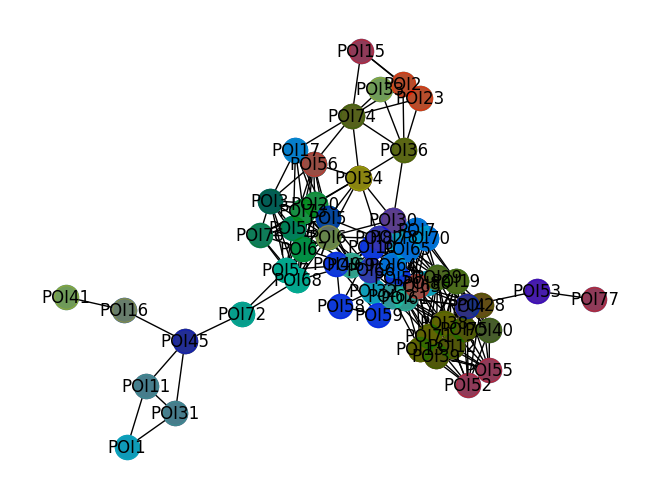

In [ ]:
G = nx.Graph()
G.add_nodes_from(data_nodes['POI'])
G.add_edges_from(zip(filtered_df['POIA'], filtered_df['POIB']))

cliques = nx.find_cliques(G)

pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True)
colors = ['r', 'g', 'b', 'y', 'c']

for i, clique in enumerate(cliques):
    nx.draw_networkx_nodes(G, pos, nodelist=clique, node_color=colors[i % len(colors)], alpha=0.5)

plt.show()


In [ ]:
G = nx.Graph()
G.add_nodes_from(data_nodes['POI'])
G.add_edges_from(zip(filtered_df['POIA'], filtered_df['POIB']))
cliques = nx.find_cliques(G)
cliques_df = pd.DataFrame(columns=['POIA', 'POIB'])

for clique in cliques:
    for i in range(len(clique)):
        for j in range(i + 1, len(clique)):
            poia = clique[i]
            poib = clique[j]
            new_row = pd.DataFrame({'POIA': [poia], 'POIB': [poib]})
            cliques_df = pd.concat([cliques_df, new_row], ignore_index=True)
print(cliques_df)


       POIA   POIB
0     POI59  POI74
1     POI59  POI73
2     POI59  POI58
3     POI59  POI10
4     POI59  POI18
...     ...    ...
9096  POI28  POI54
9097  POI28  POI72
9098  POI67  POI54
9099  POI67  POI72
9100  POI54  POI72

[9101 rows x 2 columns]


In [ ]:
cliques_df.to_excel('cliqueslinks.xlsx', index=False)

In [ ]:
cliques = list(nx.find_cliques(G))

# Membuat DataFrame kosong untuk menyimpan hasil cliques
cliques_df = pd.DataFrame(columns=['POI', 'Clique Number'])

# Iterasi setiap clique
for i, clique in enumerate(cliques):
    # Iterasi setiap simpul dalam clique
    for node in clique:
        # Tambahkan baris baru ke DataFrame dengan informasi simpul dan nomor cliques
        new_row = pd.DataFrame({'POI': [node], 'Clique Number': [i + 1]})
        cliques_df = pd.concat([cliques_df, new_row], ignore_index=True)

# Cetak hasil
print(cliques_df)

        POI Clique Number
0     POI59             1
1     POI74             1
2     POI73             1
3     POI58             1
4     POI10             1
...     ...           ...
1082  POI26            78
1083  POI28            78
1084  POI67            78
1085  POI54            78
1086  POI72            78

[1087 rows x 2 columns]


In [ ]:
cliques_df.to_excel('cliquesnodes.xlsx', index=False)

# Visualisasi

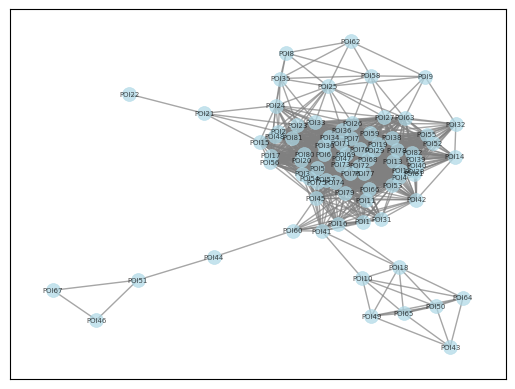

In [ ]:
# Membangun graf
G = nx.Graph()
G.add_nodes_from(data_nodes['POI'])
G.add_edges_from(zip(filtered_df['POIA'], filtered_df['POIB']))

# Menentukan posisi simpul secara visual
pos = nx.kamada_kawai_layout(G)

# Menggambar graf
#nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
nx.draw_networkx(G, pos, with_labels=True, node_size=100, node_color='lightblue', edge_color='gray', linewidths=0.5, alpha=0.7, font_size=5)

# Menampilkan visualisasi SNA
plt.show()